#### In general, ANN / MLP is slower to train and has worse accuracy than LSTM. You can call this a ``baseline model`` though.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger

In [2]:
class ANNClassifier(pl.LightningModule):
    def __init__(
        self,
        input_dim, # n_features = 2 here
        hidden_dim,
        output_dim,
        dropout,
        learning_rate=1e-3,
        criterion=nn.BCEWithLogitsLoss()
    ):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout = dropout

        self.criterion = criterion
        self.learning_rate = learning_rate

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.maxpool = nn.MaxPool1d(kernel_size=20)
                
        self.dropout = nn.Dropout(dropout)
        
        self.save_hyperparameters(ignore=['criterion'])
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.dropout(out)
        out = self.fc2(out)
        out = out.permute(0, 2, 1)
        out = self.maxpool(out)

        return out
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        out = out.squeeze()
        loss = self.criterion(out, y)

        self.log('train_loss', loss)

        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        out = out.squeeze()
        loss = self.criterion(out, y)
        acc = ((torch.sigmoid(out) > 0.5).float() == y).float().mean()

        self.log('test_loss', loss)
        self.log('test_acc', acc)

        return {'test_loss': loss, 'test_acc': acc}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        out = out.squeeze()
        loss = self.criterion(out, y)
        acc = ((torch.sigmoid(out) > 0.5).float() == y).float().mean()

        self.log('val_loss', loss)
        self.log('val_acc', acc)

        return {'val_loss': loss, 'val_acc': acc}

In [3]:
'''
All parameters are aggregated in one place.
This is useful for reporting experiment params to experiment tracking software

'''

# NOTE: Old values that were tested, are in comments
p = dict(
    # Model parameters
    input_dim = 2, # Time-series with 2 features
    hidden_dim = 100, # .., # Less data, so smaller networks may generalize better
    output_dim = 1, # Avoids the need for a sigmoid layer post Linear | Also, BCEWithLogitsLoss() performs Sigmoid internally
    # Training parameters
    batch_size = 16,
    max_epochs = 100, # 10, # Less data + ANN (less params), so we may need more epochs. NOTE: 10 is not good enough.
    dropout = 0.2, # .., # Keep low for smaller networks
    learning_rate = 0.001, # .., # Keep low for slower networks
    criterion = nn.BCEWithLogitsLoss() # Binary cross entropy loss (with logits)
)

In [4]:
# Set seed for reproducibility
seed_everything(42)

# Load data from .npz file
dat = np.load("./shuffled_data.npz")
X, y = dat['X'], dat['y'] # Shuffled data

# Use train_test_split to split the overall data into train + test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True) # random_state=42) -> Not needed since seed_everything is used
# Use train_test_split to split the training data into train + val sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True) # random_state=42) # 0.2 used earlier

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape
# (batch_size, seq_len, num_features) if batch_first=True

Global seed set to 42


((198, 20, 2), (50, 20, 2), (63, 20, 2), (198,), (50,), (63,))

In [5]:
# Convert to torch tensors and data loaders
# NOTE: You technically don't need Dataset or DataLoader for only this much data
# Using them here for consistency with other notebooks & to make it easier to scale up (wrt batching etc.) 
train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test))
train_loader = DataLoader(train_data, shuffle=True, batch_size=p['batch_size'], pin_memory=True, num_workers=4)
val_loader = DataLoader(val_data, shuffle=False, batch_size=p['batch_size'], pin_memory=True, num_workers=4)
test_loader = DataLoader(test_data, shuffle=False, batch_size=p['batch_size'], pin_memory=True, num_workers=4)

In [6]:
# Set up logger
DIR_NAME = 'ann_cf'
EXP_NUM = 0 # NOTE: Change version for each run to avoid overwriting logs
csv_logger = CSVLogger('./', name=f'{DIR_NAME}', version=f'{EXP_NUM}')

trainer = Trainer(
    max_epochs=p['max_epochs'],
    logger=csv_logger,
    log_every_n_steps=1,
    enable_progress_bar=True,
    # fast_dev_run=True # For debugging
)

model = ANNClassifier(
    input_dim=p['input_dim'],
    hidden_dim=p['hidden_dim'],
    output_dim=p['output_dim'],
    dropout=p['dropout'],
    learning_rate=p['learning_rate'],
    criterion=p['criterion']
)

# NOTE: Version 0 - 
# test_acc                    1.0
# test_loss           0.01750291744247079
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\JeS73\Desktop\Jyo - LSTM\lstm\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory ./ann_cf\0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | fc1       | Linear            | 300   
2 | fc2       | Linear            | 101   
3 | maxpool   | MaxPool1d         | 0     
4 | dropout   | Dropout           | 0     
------------------------------------------------
401       Trainable params
0         Non-trainable params
401       Total params
0.002     Total estimated model params size (MB)
c:\Users\JeS73\Desktop\Jyo - LSTM\lstm\lib\site-pa

Epoch 99: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s, v_num=0]         

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s, v_num=0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 88.12it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    1.0
        test_loss           0.01750291744247079
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.01750291744247079, 'test_acc': 1.0}]

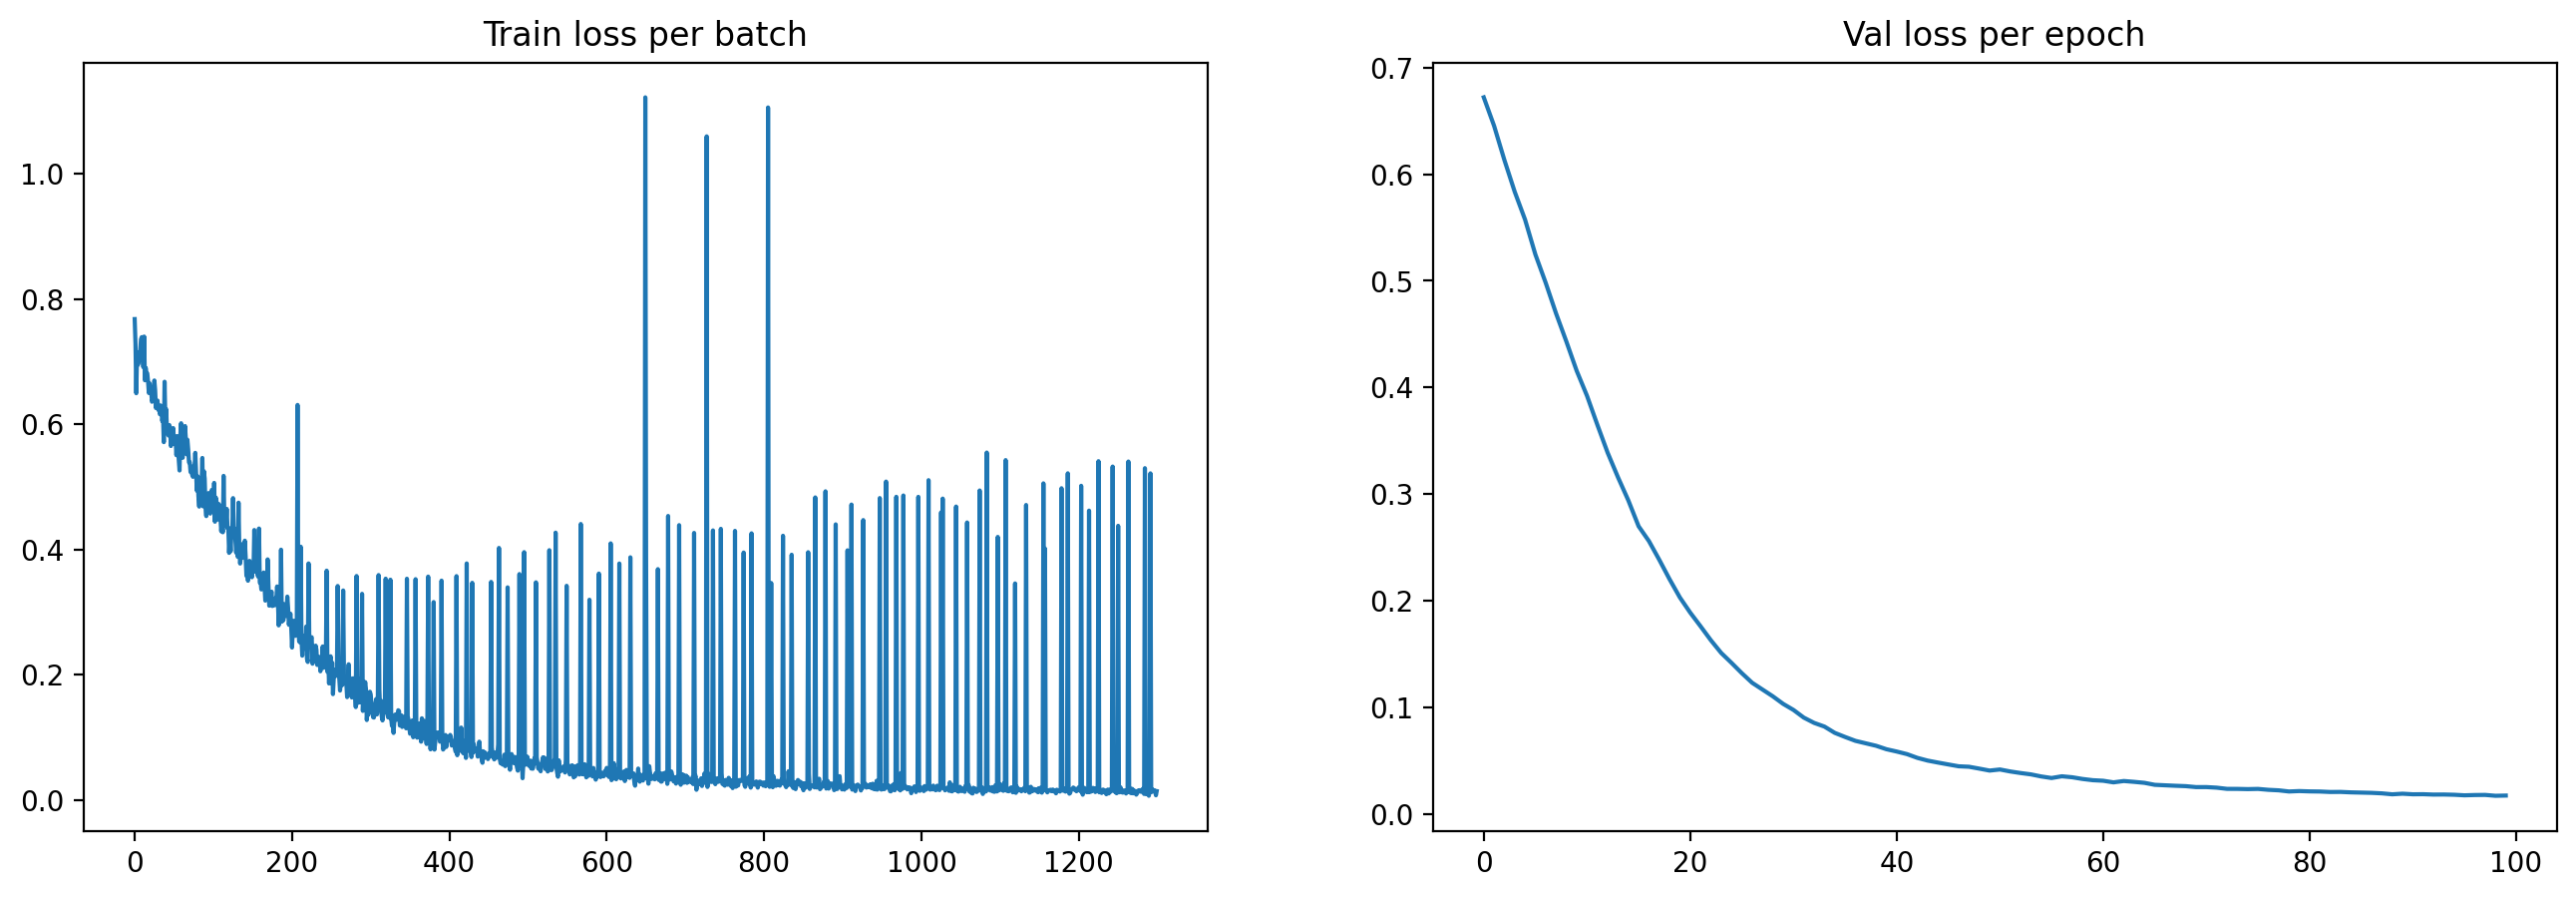

BCEWithLogits:
Train loss: 0.014
Val loss:   0.017


KeyError: 'val_acc'

In [9]:
# Load & show metrics
metrics = pd.read_csv(f'./{DIR_NAME}/{EXP_NUM}/metrics.csv')
train_loss = metrics[['train_loss', 'step', 'epoch']][~np.isnan(metrics['train_loss'])]
val_loss = metrics[['val_loss', 'epoch']][~np.isnan(metrics['val_loss'])]
test_loss = metrics['test_loss'].iloc[-1]
test_acc = metrics['test_acc'].iloc[-1]

fig, axes = plt.subplots(1, 2, figsize=(16, 5), dpi=200)
axes[0].set_title('Train loss per batch')
axes[0].plot(train_loss['step'], train_loss['train_loss'])
axes[1].set_title('Val loss per epoch')
axes[1].plot(val_loss['epoch'], val_loss['val_loss'])
plt.savefig(f'./{DIR_NAME}/{EXP_NUM}/loss.png', dpi=200)
plt.show(block = True)

print('BCEWithLogits:')
print(f"Train loss: {train_loss['train_loss'].iloc[-1]:.3f}")
print(f"Val loss:   {val_loss['val_loss'].iloc[-1]:.3f}")
print(f'Val acc:    {val_loss["val_acc"].iloc[-1]:.3f}')
print(f'Test loss: {test_loss:.3f}')
print(f'Test acc: {test_acc:.3f}')